In [1]:
%matplotlib inline
import spotipy
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.client import SpotifyException

load_dotenv()

pd.set_option('display.max_colwidth', 30)
pd.set_option('display.max_columns', 0)
pd.set_option('display.expand_frame_repr', False)

In [2]:
# Logging in
username = "113586775"

spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

In [3]:
# Which tracks was released in 2018?
release_date = []
artist_name = []
track_name = []
popularity = []
track_id = []

for i in range(0,10000,50):
    try:
        track_results = spotify.search(q='year:2018', type='track', limit=50, offset=i)
    except SpotifyException as err:
        print(i, err)
        break
        # Ignore 404 HTTP error

    if track_results is None:
        break

    for t in track_results['tracks']['items']:
        release_date.append(t['album']['release_date'])
        artist_name.append(t['artists'][0]['name'])
        track_name.append(t['name'])
        track_id.append(t['id'])
        popularity.append(t['popularity'])

print("Number of tracks: ", len(track_id))

HTTP Error for GET to https://api.spotify.com/v1/search with Params: {'q': 'year:2018', 'limit': 50, 'offset': 1000, 'type': 'track', 'market': None} returned 400 due to Bad request.


1000 http status: 400, code:-1 - https://api.spotify.com/v1/search?q=year%3A2018&limit=50&offset=1000&type=track:
 Bad request., reason: None
Number of tracks:  1000


In [4]:
# Creating a dataframe
track_df = pd.DataFrame(
    {
        'release_date': release_date,
        'artist_name': artist_name,
        'track_name': track_name,
        'track_id': track_id,
        'popularity': popularity
    }
)
track_df['release_date'] = pd.to_datetime(track_df['release_date'], format="mixed")
track_df.sort_values(by=['release_date', 'artist_name', 'track_name'], inplace=True, ignore_index=True)
# ignore_index=True: updates the indices of the dataframe

print(f"Dataframe shape: {track_df.shape}")
print("\n", track_df.head(10))
print("\n", track_df.describe())
print("\n", track_df.dtypes)

Dataframe shape: (1000, 5)

   release_date          artist_name                     track_name                track_id  popularity
0   2018-01-01  Amilcare Ponchielli  La Gioconda, Op. 9: "Suici...  3KjH5L9QMVS7XyzvBsyiGt           0
1   2018-01-01         Anna Premoli  Chapter 14.2 - What's Love...  0wv9BqksFUSTEpjRFcmtuo           0
2   2018-01-01   Anne Mette Hancock     Hoofdstuk 44.7 - Lijkbloem  4Otio645XJHdL5JWH5fiWv           0
3   2018-01-01    Banda La Sierreña       No Compro Amores (Banda)  4OF7yRdKYmInwEDXUJteZZ           7
4   2018-01-01        Björn Persson  Chapter 40.2 - Tiden läker...  1Y1EiUtJmI6n6JzcCc7jjs           0
5   2018-01-01            Blasfemia           Maestros de Libertad  146JukT5oxTLUL9D6ISilD           0
6   2018-01-01        Bob The Train                  Counting Song  0SxfRpvw06VUXDv7bXNSb4          16
7   2018-01-01        Bob The Train                  Counting Song  0SxfRpvw06VUXDv7bXNSb4          16
8   2018-01-01        Bob The Train         

No. artists:  804


array([[<Axes: title={'center': 'popularity'}>]], dtype=object)

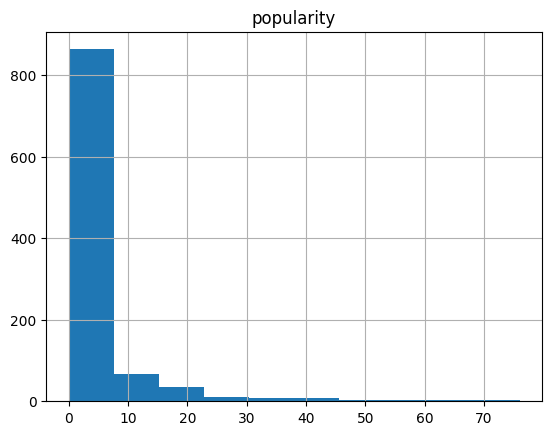

In [5]:
print("No. artists: ", track_df['artist_name'].nunique())

track_df.hist(column='popularity')

In [6]:
# Which playlists do I have?
playlists = spotify.user_playlists(username)
if playlists is None:
    print("playlists is None")
    exit(1)
print("Type: ", type(playlists))
print("Keys: ", playlists.keys())
print()

playlist_name = []
playlist_ntracks = []
playlist_id = []

for p in playlists['items']:
    playlist_name.append(p['name'])
    playlist_ntracks.append(p['tracks']['total'])
    playlist_id.append(p['id'])

playlist_df = pd.DataFrame(
    {'n_tracks': playlist_ntracks, 'id': playlist_id}, 
    index=playlist_name
    )
print(playlist_df)
print("Number of tracks in Favorites-playlist: ", playlist_df['n_tracks']['Favorites'])

Type:  <class 'dict'>
Keys:  dict_keys(['href', 'items', 'limit', 'next', 'offset', 'previous', 'total'])

                                n_tracks                      id
Favorites                           1285  2tvrDqnp3vJd6l6Cw38bVZ
Queen and other classics             107  367BXl0oqvDSbBu34T6OBH
John Mayer                           177  4h69xgBmpi8WnrCzNG0saL
Top 50 - Global                       50  37i9dQZEVXbMDoHDwVN2tF
Rock and other hard materials         86  2k19D3M2QSz3sdS0MzocSs
Party                                511  1Vs71OxUMfNXTLtp4USgTA
Blues                                 49  5na5MdXxNrFa7JUUwg14qP
Piano                                 32  4qa6CoQZqpUun4Divl1Cjg
VOLUME DENMARK                        80  37i9dQZF1DXcSNirXzsHRX
Tolkiens The Lord of the Ri...        78  4F3VK81yAvFlVquazfxVLG
Number of tracks in Favorites-playlist:  1285


In [7]:
artists = []
unique_artists = []
track_name = []
release_date = []
popularity = []
track_id = []
duration_ms = []

for i in range(0, playlist_df['n_tracks'].Favorites, 100):
    track_results = spotify.user_playlist_tracks(username, playlist_df['id'].Favorites, offset=i, limit=100)

    if track_results is None:
        print("track_results is None")
        break

    for track in track_results['items']:
        artists.append({artist['name'] for artist in track['track']['artists']})
        
        for artist in track['track']['artists']:
            if artist['name'] not in unique_artists:
                unique_artists.append(artist['name'])
        track_name.append(track['track']['name'])
        release_date.append(track['track']['album']['release_date'])
        popularity.append(track['track']['popularity'])
        track_id.append(track['track']['id'])
        duration_ms.append(track['track']['duration_ms'])

In [8]:
artists_df = pd.DataFrame(artists, columns=[f"artist_{i + 1}" for i in range(max(map(len, artists)))])

favorites_df = pd.DataFrame(
    {
        'release_date': release_date,
        'track_name': track_name,
        'popularity': popularity,
        'track_id': track_id,
        'duration_ms': duration_ms
    }
)
favorites_df['release_date'] = pd.to_datetime(favorites_df['release_date'], format="mixed")

favorites_df = pd.concat([favorites_df, artists_df], axis=1)
favorites_df.sort_values(by='release_date', inplace=True, ascending=False, ignore_index=True)
favorites_df

,release_date,track_name,popularity,track_id,duration_ms,artist_1,artist_2,artist_3,artist_4,artist_5,artist_6
0,2024-02-29,Von dutch,78,01TnMXIy7mJJQ7E8uy937N,164284,Charli XCX,None,None,None,None,None
1,2024-02-15,Training Season,91,6Qb7YsAqH4wWFUMbGsCpap,209487,Dua Lipa,None,None,None,None,None
2,2024-02-09,Gangen,54,1b4EXBzooRSOuQFGJaZOe8,193217,Pil,None,None,None,None,None
3,2024-02-02,Dreaming,64,3TBNXtO8ukvpbgvkMuttsb,208253,Tones And I,None,None,None,None,None
4,2024-02-01,Memories,72,2VDTqhsSzrRxsbjvv4KLPl,179534,Dean Lewis,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
1280,1970-04-10,Your Song,0,17VegeBoHvMlIByrdu64KR,244226,Elton John,None,None,None,None,None
1281,1968-11-22,While My Guitar Gently Wee...,0,4J4gApJKSC0himDViFotdy,285000,The Beatles,None,None,None,None,None
1282,1968-11-22,Blackbird - Remastered,0,4Z92RMiyJpUrApZi3LtpJ6,138386,The Beatles,None,None,None,None,None
1283,1968-10-25,All Along the Watchtower,75,2aoo2jlRnM3A0NyLQqMN2f,240800,Jimi Hendrix,None,None,None,None,None


,release_date,track_name,artist_1,artist_2,artist_3,artist_4,artist_5,artist_6,popularity,duration_ms,track_id
0,2024-02-29,Von dutch,Charli XCX,None,None,None,None,None,78,164284,01TnMXIy7mJJQ7E8uy937N
1,2024-02-15,Training Season,Dua Lipa,None,None,None,None,None,91,209487,6Qb7YsAqH4wWFUMbGsCpap
2,2024-02-09,Gangen,Pil,None,None,None,None,None,54,193217,1b4EXBzooRSOuQFGJaZOe8
3,2024-02-02,Dreaming,Tones And I,None,None,None,None,None,64,208253,3TBNXtO8ukvpbgvkMuttsb
4,2024-02-01,Memories,Dean Lewis,None,None,None,None,None,72,179534,2VDTqhsSzrRxsbjvv4KLPl
...,...,...,...,...,...,...,...,...,...,...,...
1280,1970-04-10,Your Song,Elton John,None,None,None,None,None,0,244226,17VegeBoHvMlIByrdu64KR
1281,1968-11-22,While My Guitar Gently Wee...,The Beatles,None,None,None,None,None,0,285000,4J4gApJKSC0himDViFotdy
1282,1968-11-22,Blackbird - Remastered,The Beatles,None,None,None,None,None,0,138386,4Z92RMiyJpUrApZi3LtpJ6
1283,1968-10-25,All Along the Watchtower,Jimi Hendrix,None,None,None,None,None,75,240800,2aoo2jlRnM3A0NyLQqMN2f


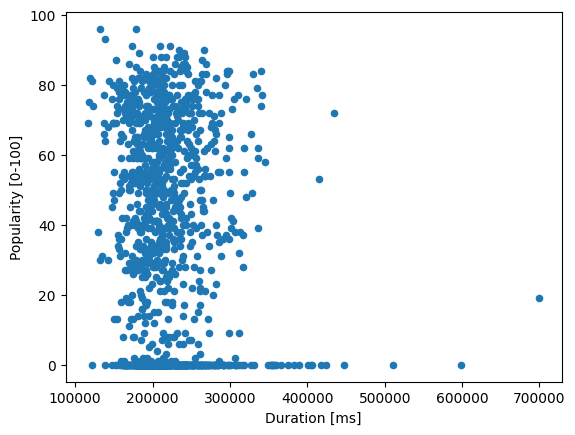

In [9]:
cols = [
    'release_date',
    'track_name',
    'artist_1',
    'artist_2',
    'artist_3',
    'artist_4',
    'artist_5',
    'artist_6',
    'popularity',
    'duration_ms',
    'track_id'
]
favorites_df = favorites_df[cols]

favorites_df.plot.scatter(
    x='duration_ms', y='popularity', 
    xlabel='Duration [ms]', ylabel='Popularity [0-100]'
)

favorites_df

In [10]:
favorites_df.groupby(['artist_1', 'artist_2']).popularity.count()

artist_1        artist_2         
21 Savage       Post Malone          1
220 KID         Nathan Evans         1
A$AP Rocky      Selena Gomez         1
AFROJACK        Bebe Rexha           1
Action Bronson  Chance the Rapper    1
                                    ..
benny blanco    Justin Bieber        1
kai             Flume                1
mansionz        Spark Master Tape    1
shy martin      Mike Perry           1
will.i.am       The Script           1
Name: popularity, Length: 317, dtype: int64

In [11]:
favorites_df.groupby('artist_1').popularity.agg([len, "min", "max"])

,len,min,max
artist_1,,,
21 Savage,1,0,0
220 KID,1,69,69
3 Doors Down,8,0,8
5 Seconds of Summer,3,66,82
A Tribe Called Quest,1,52,52
...,...,...,...
kai,1,0,0
mags,1,14,14
mansionz,1,0,0
